<a href="https://colab.research.google.com/github/fidelis2025/stankelly-website/blob/main/SiTns_Paper1_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

REQUIRED PACKAGE Installation

In [2]:
pip install pandas numpy matplotlib seaborn scikit-learn statsmodels pmdarima prophet tensorflow keras arch tslearn


  Using cached pmdarima-2.1.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (8.5 kB)
  Using cached arch-8.0.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (13 kB)
  Using cached tslearn-0.7.0-py3-none-any.whl.metadata (16 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.7/372.7 kB 22.5 MB/s eta 0:00:00


Drive Mounting and Data Uploading

In [4]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Step 1: Upload file manually
from google.colab import files
import pandas as pd

uploaded = files.upload()  # This lets you pick file from your PC
file_path = list(uploaded.keys())[0]  # Automatically use uploaded filename

# Step 2: Read dataset
# Use pd.read_excel for .xlsx files
data = pd.read_excel(file_path)
print("Temperature Data (first 5 rows):")
print(data.head())

Saving Temperature Data.xlsx to Temperature Data.xlsx
Temperature Data (first 5 rows):
   City  Temperature  Urban_Population
0  ARUA         30.8             4.417
1  ARUA         32.3             4.617
2  ARUA         31.0             4.826
3  ARUA         29.1             5.045
4  ARUA         28.7             5.273


Data Preprocessing


Descriptive Statistics

       Temperature  Urban_Population
count   132.000000        132.000000
mean     28.793182          9.297394
std       2.032229          5.868116
min      23.800000          3.460158
25%      27.775000          5.684159
50%      28.600000          6.759670
75%      30.125000         11.170500
max      34.200000         26.771000


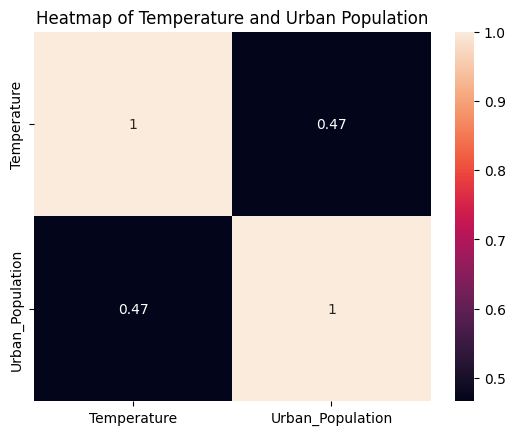


ADF Test for Average Temperature
ADF Statistic: -3.4066703548963684
P value: 0.010733570588527978
Used Lag: 0

ADF Test for Urban Population
ADF Statistic: -1.7776647806432928
P value: 0.39160552447873126
Used Lag: 0
Isolation Forest Results Summary
Outlier_Label
Normal     125
Outlier      7
Name: count, dtype: int64

Detected Outliers
    Temperature  Urban_Population
25         32.6             9.152
49         32.3            18.878
58         29.9            23.774
60         33.6            24.954
61         34.2            25.553
62         32.2            26.159
63         32.4            26.771


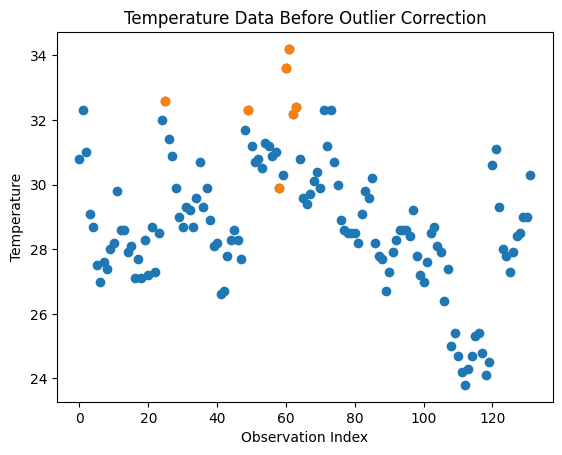

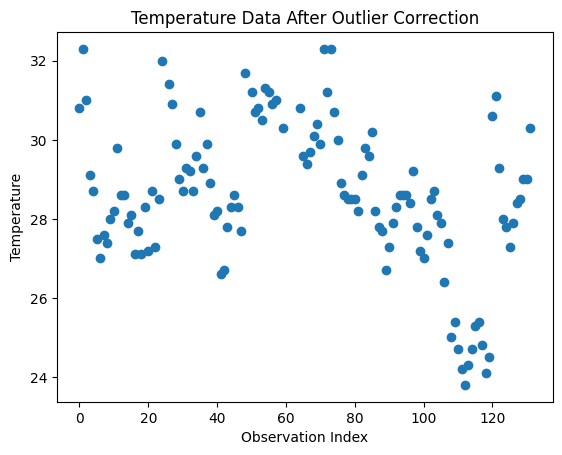


Original data size: 132
Cleaned data size: 125


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional
from scipy.stats import pearsonr

# Step 2: Read dataset (already uploaded via files.upload())
file_path = "Temperature Data.xlsx"
df = pd.read_excel(file_path)
df.columns = ["City", "Temperature", "Urban_Population"]

print("\nDescriptive Statistics\n")
print(df.describe())

plt.figure()
sns.heatmap(df[["Temperature", "Urban_Population"]].corr(), annot=True)
plt.title("Heatmap of Temperature and Urban Population")
plt.show()

def adf_test(series, name):
    result = adfuller(series, autolag="AIC")
    print(f"\nADF Test for {name}")
    print(f"ADF Statistic: {result[0]}")
    print(f"P value: {result[1]}")
    print(f"Used Lag: {result[2]}")

adf_test(df["Temperature"], "Average Temperature")
adf_test(df["Urban_Population"], "Urban Population")

# Fit Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
df["Outlier"] = iso.fit_predict(df[["Temperature", "Urban_Population"]])

# Map results to readable labels
df["Outlier_Label"] = df["Outlier"].map({1: "Normal", -1: "Outlier"})

# Print summary of results
print("Isolation Forest Results Summary")
print(df["Outlier_Label"].value_counts())

# Display detected outliers
print("\nDetected Outliers")
print(df[df["Outlier"] == -1][["Temperature", "Urban_Population"]])

# Plot BEFORE outlier correction (actual data)
plt.figure()
plt.scatter(df.index, df["Temperature"])
plt.scatter(
    df[df["Outlier"] == -1].index,
    df[df["Outlier"] == -1]["Temperature"]
)
plt.title("Temperature Data Before Outlier Correction")
plt.xlabel("Observation Index")
plt.ylabel("Temperature")
plt.show()

# Remove outliers
df_clean = df[df["Outlier"] == 1].drop(columns=["Outlier", "Outlier_Label"])

# Plot AFTER outlier correction (cleaned data)
plt.figure()
plt.scatter(df_clean.index, df_clean["Temperature"])
plt.title("Temperature Data After Outlier Correction")
plt.xlabel("Observation Index")
plt.ylabel("Temperature")
plt.show()

# Confirm cleaned data size
print("\nOriginal data size:", df.shape[0])
print("Cleaned data size:", df_clean.shape[0])

Model Fitting

In [26]:
# Step 1: Upload file manually
from google.colab import files
import pandas as pd

uploaded = files.upload()  # This lets you pick file from your PC
file_path = list(uploaded.keys())[0]  # Automatically use uploaded filename

# Step 2: Read dataset
# Use pd.read_excel for .xlsx files
data = pd.read_excel(file_path)
print("Temperature Data (first 5 rows):")
print(data.head())

Saving Temperature Data.xlsx to Temperature Data (1).xlsx
Temperature Data (first 5 rows):
   Date  City  Temperature  Urban_Population
0  2012  ARUA         30.8             4.417
1  2013  ARUA         32.3             4.617
2  2014  ARUA         31.0             4.826
3  2015  ARUA         29.1             5.045
4  2016  ARUA         28.7             5.273


Forecast Using ARIMA-LSTM

/tmp/ipython-input-4207585334.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df["Date"] = pd.date_range(start="2017-01", periods=len(df), freq="M")
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-4207585334.py:71: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="2024-01", periods=steps, freq="M")



Forecasted Temperature Dynamics for ARUA (2024–2035)
Date
2024    29.03
2025    28.88
2026    28.91
2027    28.91
2028    28.91
2029    28.91
2030    28.91
2031    28.91
2032    28.91
2033    28.91
2034    28.91
2035    28.91
Name: Forecast_Temperature, dtype: float64


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-4207585334.py:71: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="2024-01", periods=steps, freq="M")



Forecasted Temperature Dynamics for ENTEBBE (2024–2035)
Date
2024    27.73
2025    27.71
2026    27.71
2027    27.72
2028    27.72
2029    27.72
2030    27.72
2031    27.72
2032    27.72
2033    27.72
2034    27.72
2035    27.72
Name: Forecast_Temperature, dtype: float64


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-4207585334.py:71: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="2024-01", periods=steps, freq="M")



Forecasted Temperature Dynamics for GULU (2024–2035)
Date
2024    30.60
2025    30.70
2026    30.47
2027    30.37
2028    30.49
2029    30.58
2030    30.52
2031    30.46
2032    30.48
2033    30.52
2034    30.51
2035    30.49
Name: Forecast_Temperature, dtype: float64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-4207585334.py:71: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="2024-01", periods=steps, freq="M")



Forecasted Temperature Dynamics for KAMPALA (2024–2035)
Date
2024    27.72
2025    27.73
2026    27.72
2027    27.72
2028    27.72
2029    27.72
2030    27.72
2031    27.72
2032    27.72
2033    27.72
2034    27.72
2035    27.72
Name: Forecast_Temperature, dtype: float64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-4207585334.py:71: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="2024-01", periods=steps, freq="M")



Forecasted Temperature Dynamics for KASESE (2024–2035)
Date
2024    30.95
2025    30.96
2026    30.96
2027    30.96
2028    30.96
2029    30.96
2030    30.96
2031    30.96
2032    30.96
2033    30.96
2034    30.96
2035    30.96
Name: Forecast_Temperature, dtype: float64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-4207585334.py:71: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="2024-01", periods=steps, freq="M")



Forecasted Temperature Dynamics for LIRA (2024–2035)
Date
2024    30.25
2025    30.81
2026    30.86
2027    30.86
2028    30.86
2029    30.86
2030    30.86
2031    30.86
2032    30.86
2033    30.86
2034    30.86
2035    30.86
Name: Forecast_Temperature, dtype: float64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-4207585334.py:71: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="2024-01", periods=steps, freq="M")



Forecasted Temperature Dynamics for MASINDI (2024–2035)
Date
2024    28.87
2025    29.23
2026    29.24
2027    29.25
2028    29.25
2029    29.25
2030    29.25
2031    29.25
2032    29.25
2033    29.25
2034    29.25
2035    29.25
Name: Forecast_Temperature, dtype: float64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-4207585334.py:71: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="2024-01", periods=steps, freq="M")



Forecasted Temperature Dynamics for JINJA (2024–2035)
Date
2024    27.83
2025    27.83
2026    27.83
2027    27.83
2028    27.83
2029    27.83
2030    27.83
2031    27.83
2032    27.83
2033    27.83
2034    27.83
2035    27.83
Name: Forecast_Temperature, dtype: float64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-4207585334.py:71: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="2024-01", periods=steps, freq="M")



Forecasted Temperature Dynamics for MBARARA (2024–2035)
Date
2024    27.77
2025    27.69
2026    27.69
2027    27.69
2028    27.69
2029    27.69
2030    27.69
2031    27.69
2032    27.69
2033    27.69
2034    27.69
2035    27.69
Name: Forecast_Temperature, dtype: float64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-4207585334.py:71: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="2024-01", periods=steps, freq="M")



Forecasted Temperature Dynamics for KABALE (2024–2035)
Date
2024    24.50
2025    24.41
2026    24.41
2027    24.41
2028    24.41
2029    24.41
2030    24.41
2031    24.41
2032    24.41
2033    24.41
2034    24.41
2035    24.41
Name: Forecast_Temperature, dtype: float64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-4207585334.py:71: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="2024-01", periods=steps, freq="M")



Forecasted Temperature Dynamics for SOROTI (2024–2035)
Date
2024    28.60
2025    28.54
2026    28.54
2027    28.54
2028    28.54
2029    28.54
2030    28.54
2031    28.54
2032    28.54
2033    28.54
2034    28.54
2035    28.54
Name: Forecast_Temperature, dtype: float64


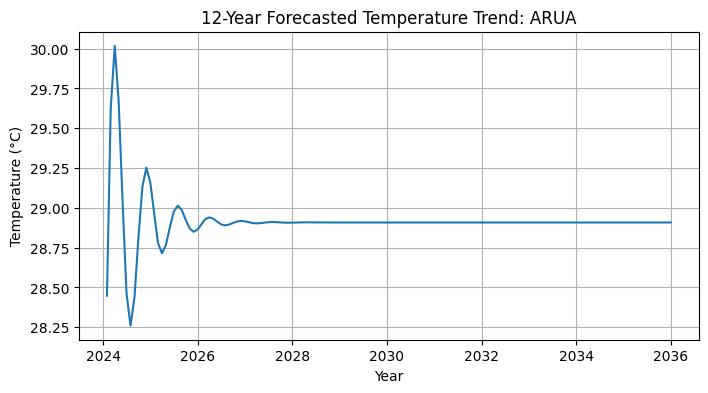

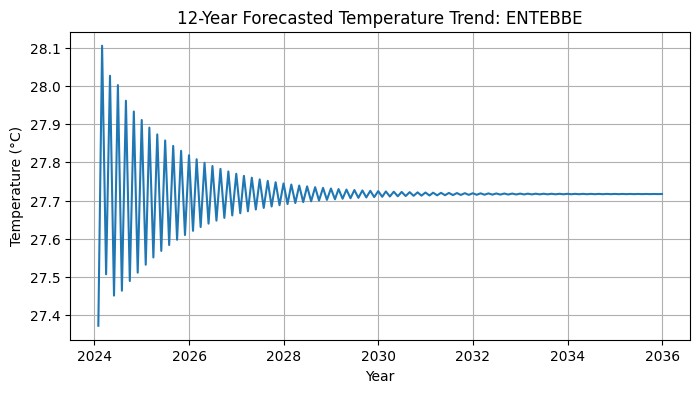

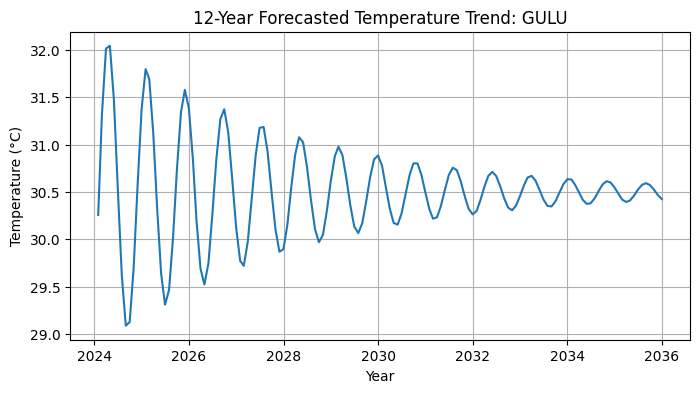

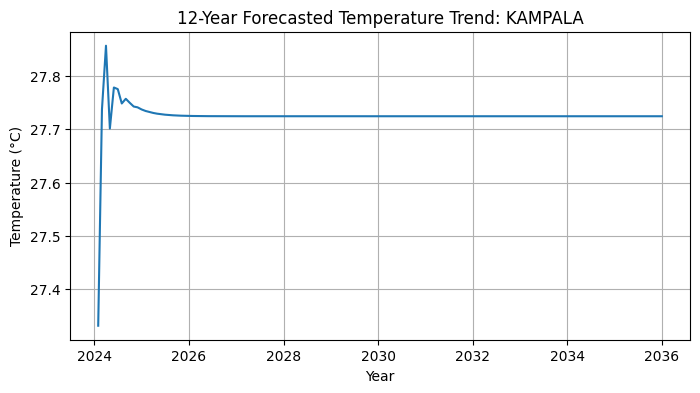

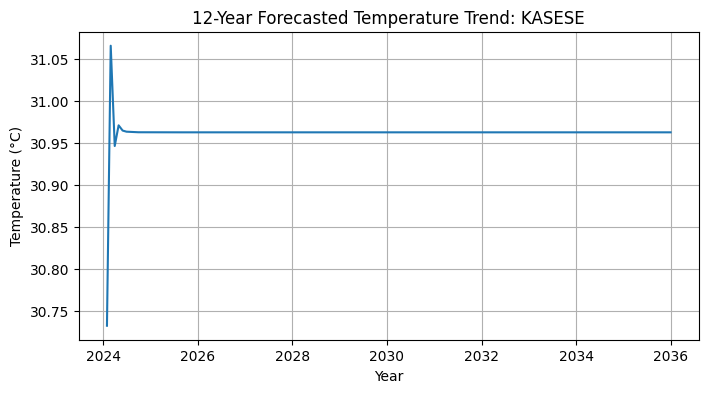

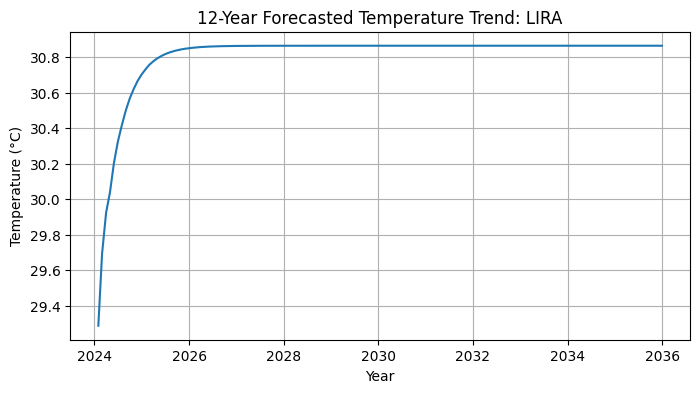

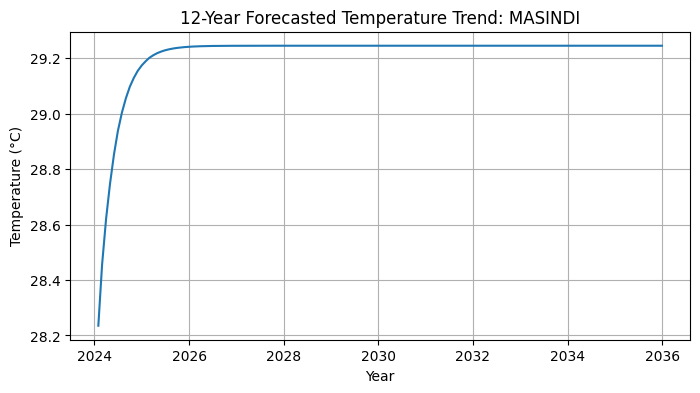

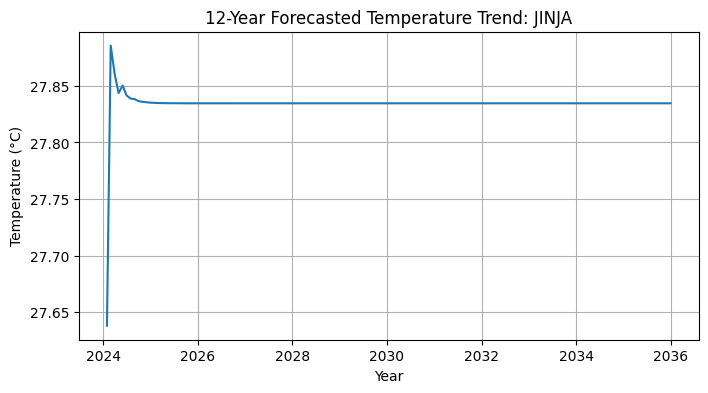

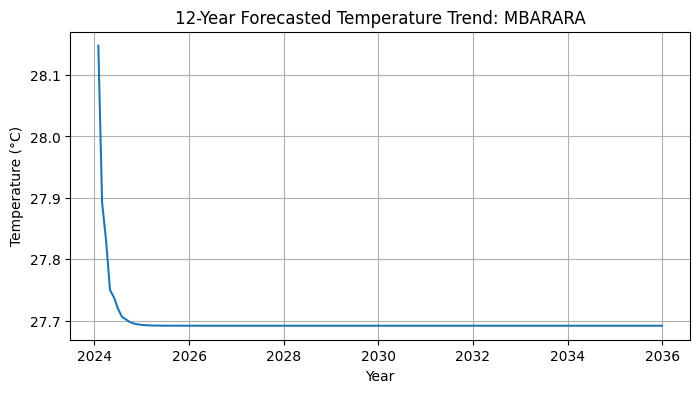

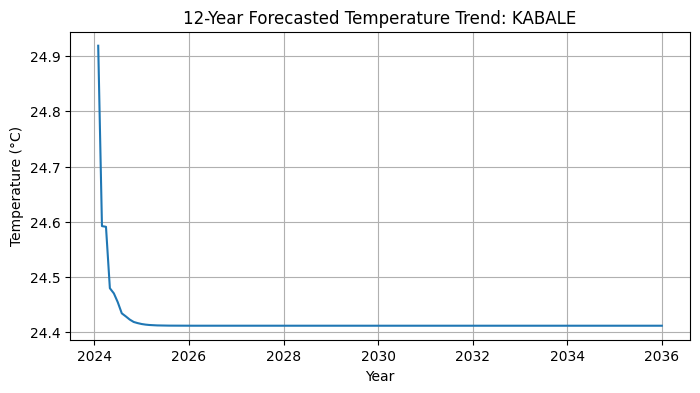

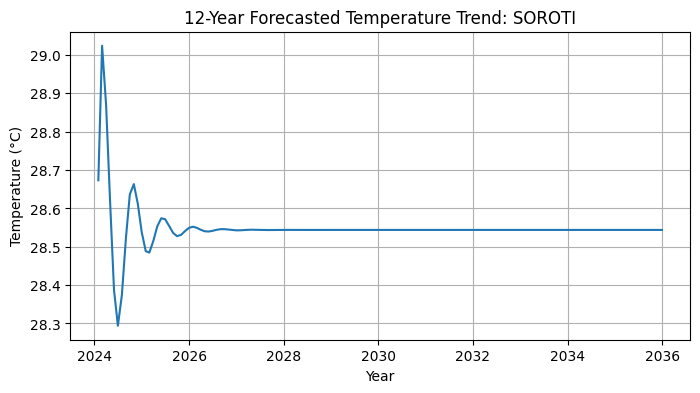

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional
from scipy.stats import pearsonr

# Step 2: Read dataset (already uploaded via files.upload())
file_path = "Temperature Data.xlsx"
df = pd.read_excel(file_path)
df.columns = ["City", "Temperature", "Urban_Population"]

# Ensure proper datetime index
df["Date"] = pd.date_range(start="2017-01", periods=len(df), freq="M")

def hybrid_forecast_city(city_df, city_name, n_years=12, n_steps=3):
    y = city_df["Temperature"].values

    # Split
    train_size = int(len(y) * 0.7)
    y_train = y[:train_size]

    # ARIMA
    auto_arima = pm.auto_arima(y_train, seasonal=False, suppress_warnings=True)
    arima_model = ARIMA(y_train, order=auto_arima.order).fit()

    # Residuals
    res_train = y_train - arima_model.fittedvalues
    scaler_res = MinMaxScaler()
    res_scaled = scaler_res.fit_transform(res_train.reshape(-1, 1))

    # Residual sequences
    Xr, yr = create_seq(res_scaled, n_steps)

    lstm_res = build_model(LSTM, (Xr.shape[1], 1))
    lstm_res.fit(Xr, yr, epochs=30, verbose=0)

    # Forecast horizon
    steps = n_years * 12

    # ARIMA forecast
    arima_fc = arima_model.forecast(steps)

    # LSTM residual forecast (iterative)
    res_fc = []
    current = res_scaled[-n_steps:].reshape(1, n_steps, 1)

    for _ in range(steps):
        pred = lstm_res.predict(current, verbose=0)[0, 0]
        res_fc.append(pred)
        current = np.append(current[:, 1:, :], [[[pred]]], axis=1)

    res_fc = scaler_res.inverse_transform(np.array(res_fc).reshape(-1, 1)).flatten()

    # Hybrid forecast
    hybrid_fc = arima_fc + res_fc

    dates = pd.date_range(start="2024-01", periods=steps, freq="M")

    forecast_df = pd.DataFrame({
        "Date": dates,
        "Forecast_Temperature": hybrid_fc
    })

    return forecast_df

city_forecasts = {}

for city in df["City"].unique():
    city_df = df[df["City"] == city].reset_index(drop=True)
    fc = hybrid_forecast_city(city_df, city)
    city_forecasts[city] = fc

    print(f"\nForecasted Temperature Dynamics for {city} (2024–2035)")
    print(fc.groupby(fc["Date"].dt.year)["Forecast_Temperature"].mean().round(2))
for city, fc in city_forecasts.items():
    plt.figure(figsize=(8,4))
    plt.plot(fc["Date"], fc["Forecast_Temperature"])
    plt.title(f"12-Year Forecasted Temperature Trend: {city}")
    plt.xlabel("Year")
    plt.ylabel("Temperature (°C)")
    plt.grid(True)
    plt.show()


ARIMA Parameters
[29.21344638  0.74678495  0.92551191]


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Hybrid Model Parameters


Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_46 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

/tmp/ipython-input-2430634362.py:132: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  prophet_df["ds"] = pd.date_range(start="2017", periods=len(prophet_df), freq="M")
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


None


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(



RandomForest Parameters
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

DecisionTree Parameters
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}

SVR Parameters
{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}

GBM Parameters
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedma

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MODEL PERFORMANCE COMPARISON

                RMSE     MAE    MAPE   SMAPE      R2
BiRNN         1.2834  0.8630  3.1747  3.1706  0.5735
BiGRU         1.7092  1.3495  5.1070  4.9938  0.2436
LSTM          1.7111  1.3516  5.0724  4.9863  0.2419
MLP           1.7123  1.3177  4.8928  4.8486  0.2408
RNN           1.7854  1.2783  4.7079  4.6997  0.1747
GRU           1.7906  1.4263  5.4135  5.2738  0.1698
RandomForest  1.8257  1.3897  5.3492  5.1674  0.1369
DecisionTree  1.8864  1.5605  5.9261  5.7740  0.0786
GBM           1.9190  1.5062  5.7782  5.5826  0.0465
KNN           2.1779  1.6511  6.3950  6.0963 -0.2281
SVR           2.3415  1.7699  6.8776  6.5179 -0.4196
Prophet       2.3781  1.8977  6.8644  7.0819 -0.4644
ARIMA-LSTM    2.6946  2.0933  8.1515  7.6366 -0.8799
ARIMA         2.7774  2.1776  8.4755  7.9250 -0.9974


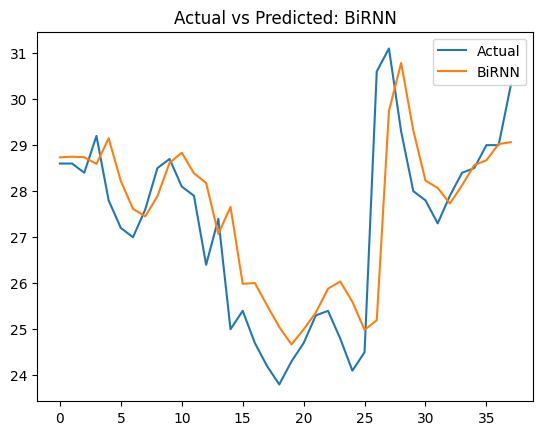

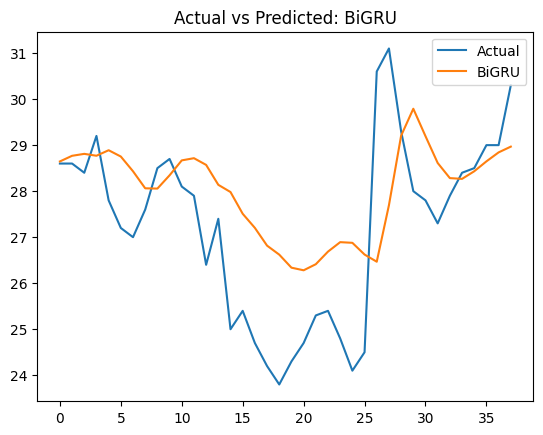

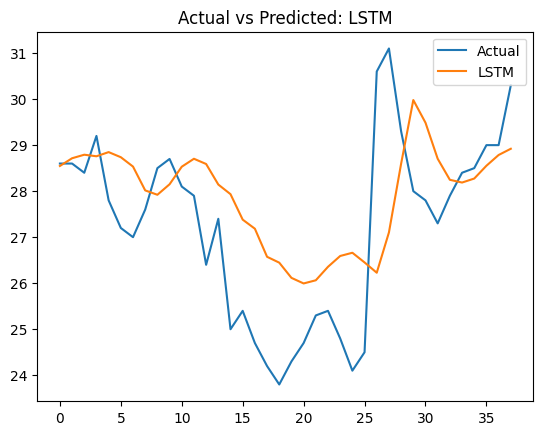

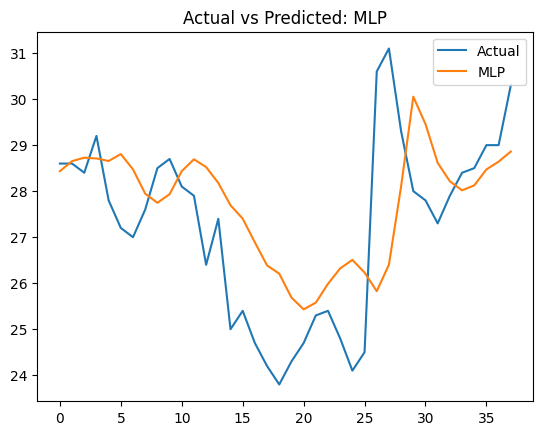

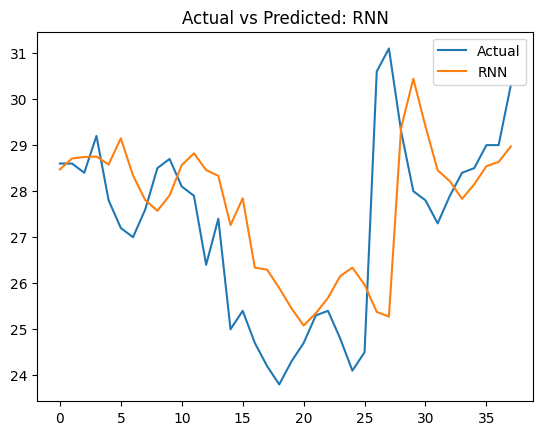

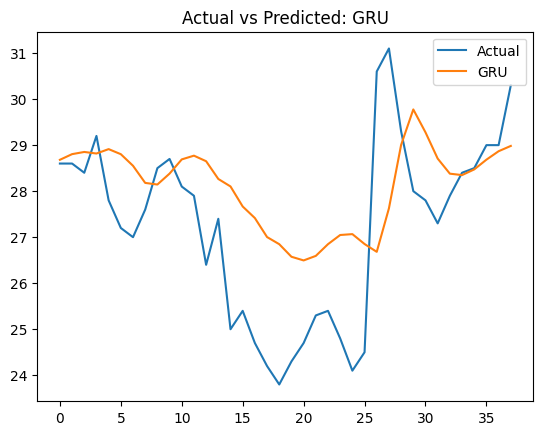

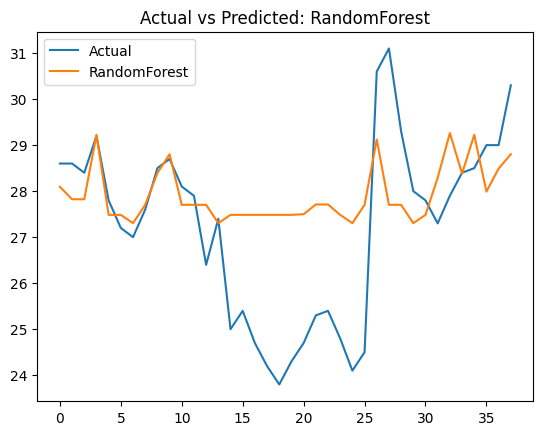

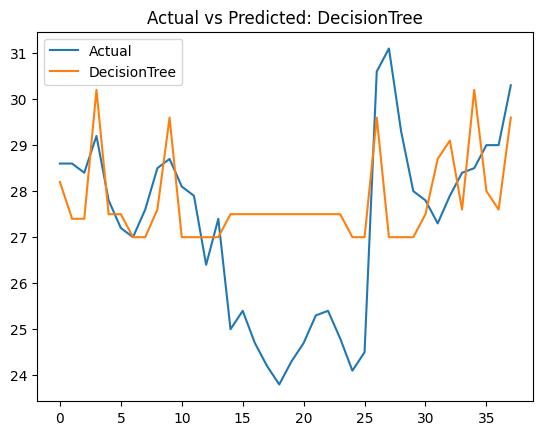

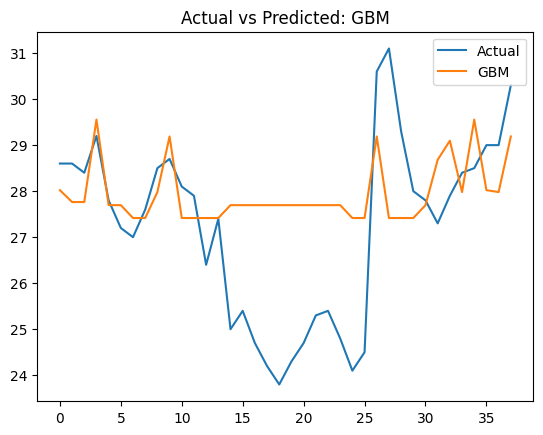

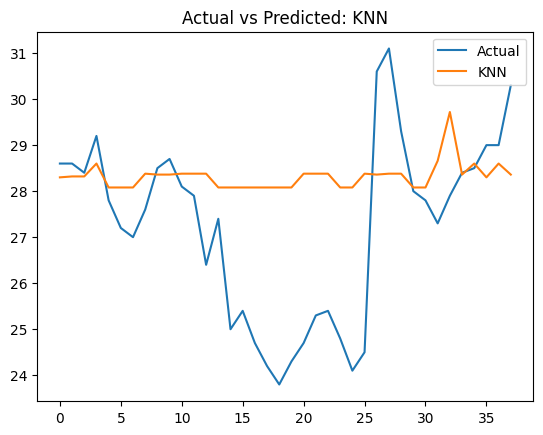

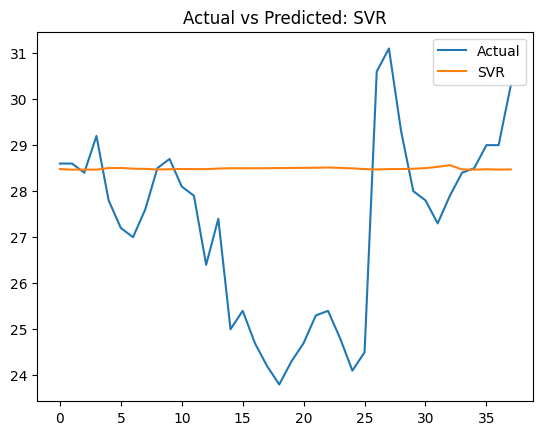

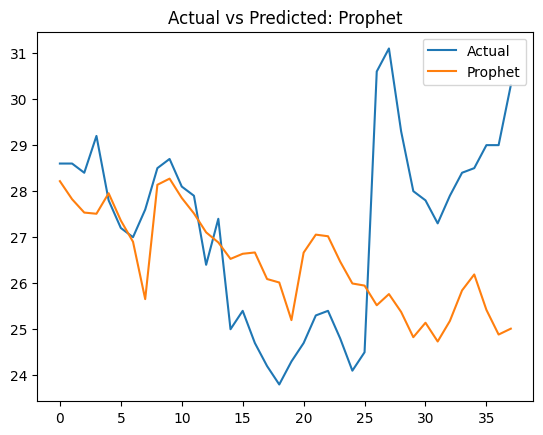

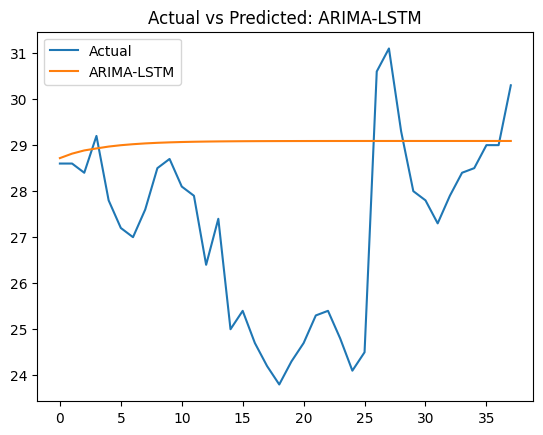


Correlation between Actual (Test) and Hybrid Prediction (Test): -0.2547318482191601

CLASSIFICATION METRICS (Derived Temperature State)

              Accuracy  Precision  Sensitivity      F1     AUC
BiRNN           0.8684     0.6667       0.5714  0.6154  0.7972
BiGRU           0.8158     0.5000       0.2857  0.3636  0.6959
LSTM            0.7895     0.3333       0.1429  0.2000  0.6452
MLP             0.7632     0.0000       0.0000  0.0000  0.5945
RNN             0.7895     0.4000       0.2857  0.3333  0.6221
GRU             0.7895     0.4000       0.2857  0.3333  0.6820
RandomForest    0.8158     0.5000       0.2857  0.3636  0.8018
DecisionTree    0.8158     0.5000       0.4286  0.4615  0.6889
GBM             0.8158     0.5000       0.4286  0.4615  0.6912
KNN             0.7895     0.0000       0.0000  0.0000  0.7212
SVR             0.8158     0.0000       0.0000  0.0000  0.1705
Prophet         0.8158     0.0000       0.0000  0.0000  0.2212
ARIMA-LSTM      0.2632     0.2000       1.0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



CROSS VALIDATION RMSE

RandomForest    1.8821
DecisionTree    2.1704
SVR             1.7839
GBM             2.1513
KNN             1.8100
dtype: float64

Best Parameters for RandomForest
{'max_depth': 3, 'n_estimators': 200}

Best Parameters for SVR
{'C': 1, 'gamma': 'scale'}

Best Parameters for GBM
{'learning_rate': 0.01, 'n_estimators': 100}

PREDICTION INTERVAL COVERAGE

RandomForest    0.5263
DecisionTree    0.6316
SVR             0.0526
GBM             0.5789
KNN             0.3421
Prophet         0.6579
LSTM            0.7895
RNN             0.9474
GRU             0.6316
BiLSTM          0.7895
BiGRU           0.6842
BiRNN           0.9737
MLP             0.8684
dtype: float64


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score

# Step 2: Read dataset (already uploaded via files.upload())
file_path = "Temperature Data.xlsx"
df = pd.read_excel(file_path)
df.columns = ["City", "Temperature", "Urban_Population"]

# TRAIN TEST SPLIT
train_size = int(len(df_clean) * 0.7)
train = df_clean.iloc[:train_size]
test = df_clean.iloc[train_size:]

y_train = train["Temperature"].values
y_test = test["Temperature"].values
x_train = train["Urban_Population"].values
x_test = test["Urban_Population"].values

# PERFORMANCE METRICS
def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, mape, smape, r2

# DEEP LEARNING BENCHMARKS
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_clean[["Temperature"]])

def create_seq(data, n_steps=3):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

# Create sequences from the entire scaled dataset
X_seq, y_seq = create_seq(scaled)

# Determine the split points for deep learning data to align test set length with y_test
dl_test_samples = len(y_test)
dl_train_samples = len(y_seq) - dl_test_samples

X_train_dl_seq, X_test_dl_seq = X_seq[:dl_train_samples], X_seq[dl_train_samples:]
y_train_dl_seq, y_test_dl_seq = y_seq[:dl_train_samples], y_seq[dl_train_samples:]

# Generic builder for recurrent models, now accepting input_seq_shape
def build_model(cell, input_seq_shape, bidirectional=False):
    model = Sequential()

    if bidirectional:
        model.add(
            Bidirectional(
                cell(50, activation="tanh"),
                input_shape=input_seq_shape
            )
        )
    else:
        model.add(
            cell(50, activation="tanh", input_shape=input_seq_shape)
        )

    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")
    return model

# ARIMA MODEL
# Train ARIMA on the training data
auto_arima = pm.auto_arima(y_train, seasonal=False)
arima_model = ARIMA(y_train, order=auto_arima.order).fit()

print("\nARIMA Parameters")
print(arima_model.params)

# Forecast for the test period
arima_pred = arima_model.forecast(len(y_test))

#ARIMA-LSTM HYBRID
# Calculate residuals from ARIMA model on TRAINING data
residuals_train = y_train - arima_model.fittedvalues
scaler_res = MinMaxScaler() # Use a separate scaler for residuals
res_scaled_train = scaler_res.fit_transform(residuals_train.reshape(-1,1))

# Create sequences for LSTM training from scaled residuals
n_steps = 3 # from create_seq function
Xr_train_res, yr_train_res = create_seq(res_scaled_train, n_steps=n_steps)
lstm_res = build_model(LSTM, (Xr_train_res.shape[1], 1)) # input_shape must be consistent with Xr_train_res
lstm_res.fit(Xr_train_res, yr_train_res, epochs=30, verbose=0)

# Forecast future residuals for the test period iteratively
res_forecast_list = []
# Initialize with the last n_steps of training residuals
current_input_res = res_scaled_train[-n_steps:].reshape(1, n_steps, 1)

for _ in range(len(y_test)):
    next_residual_scaled = lstm_res.predict(current_input_res, verbose=0)[0, 0] # verbose=0 to suppress output
    res_forecast_list.append(next_residual_scaled)
    # Update current_input by removing the first element and adding the new prediction
    # This creates a sliding window for multi-step forecasting
    current_input_res = np.append(current_input_res[:, 1:, :], [[[next_residual_scaled]]], axis=1)

res_forecast = scaler_res.inverse_transform(np.array(res_forecast_list).reshape(-1, 1)).flatten()
hybrid_pred = arima_pred + res_forecast

print("\nHybrid Model Parameters")
print(lstm_res.summary())


# FACEBOOK PROPHET
prophet_df = df_clean.reset_index()
prophet_df["ds"] = pd.date_range(start="2017", periods=len(prophet_df), freq="M")
prophet_df.rename(columns={"Temperature":"y"}, inplace=True)

model_p = Prophet()
model_p.fit(prophet_df.iloc[:train_size])

future = model_p.make_future_dataframe(periods=len(y_test), freq="M")
forecast = model_p.predict(future)
prophet_pred = forecast["yhat"].iloc[-len(y_test):].values

# MACHINE LEARNING BENCHMARKS

X_ml = df_clean[["Urban_Population"]]
y_ml = df_clean[["Temperature"]]
# Split ML data into train and test
X_train_ml, X_test_ml = X_ml.iloc[:train_size], X_ml.iloc[train_size:]
y_train_ml, y_test_ml = y_ml.iloc[:train_size], y_ml.iloc[train_size:]

ml_models = {
    "RandomForest": RandomForestRegressor(),
    "DecisionTree": DecisionTreeRegressor(),
    "SVR": SVR(),
    "GBM": GradientBoostingRegressor(),
    "KNN": KNeighborsRegressor()
}

predictions = {}
for name, model in ml_models.items():
    # Train ML models on training data
    model.fit(X_train_ml, y_train)
    # Predict on test data
    pred = model.predict(X_test_ml)
    predictions[name] = pred
    print(f"\n{name} Parameters")
    print(model.get_params())

# Add Prophet predictions to the dictionary as well
predictions["Prophet"] = prophet_pred

# Deep learning models
# Build models with appropriate input shape for training data
models_dl = {
    "LSTM": build_model(LSTM, (X_train_dl_seq.shape[1], 1)),
    "RNN": build_model(SimpleRNN, (X_train_dl_seq.shape[1], 1)),
    "GRU": build_model(GRU, (X_train_dl_seq.shape[1], 1)),
    "BiLSTM": build_model(LSTM, (X_train_dl_seq.shape[1], 1), bidirectional=True),
    "BiGRU": build_model(GRU, (X_train_dl_seq.shape[1], 1), bidirectional=True),
    "BiRNN": build_model(SimpleRNN, (X_train_dl_seq.shape[1], 1), bidirectional=True),
}

# MLP requires flattened input
mlp = Sequential()
mlp.add(Dense(50, activation="relu", input_dim=X_train_dl_seq.shape[1]))
mlp.add(Dense(1))
mlp.compile(optimizer="adam", loss="mse")

models_dl["MLP"] = mlp

# Train deep learning models on training data and predict on test data
for name, model in models_dl.items():
    # Train on training sequences
    model.fit(X_train_dl_seq if name != "MLP" else X_train_dl_seq.reshape(X_train_dl_seq.shape[0], -1),
              y_train_dl_seq,
              epochs=30,
              verbose=0)

    # Predict on test sequences
    preds = model.predict(
        X_test_dl_seq if name != "MLP" else X_test_dl_seq.reshape(X_test_dl_seq.shape[0], -1),
        verbose=0 # Suppress predict output for each model
    )

    predictions[name] = scaler.inverse_transform(preds).flatten()

# MODEL COMPARISON
# Initialize results dictionary
results = {}

# Explicit list of deep learning benchmark models
deep_learning_models = [
    "LSTM",
    "RNN",
    "GRU",
    "BiGRU",
    "BiRNN",
    "MLP"
]

# Explicit list of machine learning benchmark models
machine_learning_models = [
    "RandomForest",
    "DecisionTree",
    "SVR",
    "GBM",
    "KNN"
]

# Add ARIMA
results["ARIMA"] = metrics(y_test, arima_pred)

# Add Facebook Prophet
results["Prophet"] = metrics(y_test, prophet_pred)

# Add ARIMA-LSTM Hybrid
results["ARIMA-LSTM"] = metrics(y_test, hybrid_pred)

# Add Deep Learning Models
for model in deep_learning_models:
    if model in predictions:
        results[model] = metrics(y_test, predictions[model])

# Add Machine Learning Models
for model in machine_learning_models:
    if model in predictions:
        results[model] = metrics(y_test, predictions[model])

# Create comparison table
results_df = pd.DataFrame(
    results,
    index=["RMSE", "MAE", "MAPE", "SMAPE", "R2"]
).T

# Sort models by RMSE (best on top)
results_df = results_df.sort_values(by="RMSE")

print("\nMODEL PERFORMANCE COMPARISON\n")
print(results_df.round(4))

# VISUALIZATION ACTUAL VS PREDICTED
for name in results_df.index[:-1]: # Iterate only over names
    plt.figure()
    plt.plot(y_test, label="Actual")
    # Check if the model name exists in predictions dictionary before plotting
    if name in predictions:
        plt.plot(predictions[name], label=name)
    else:
        # Handle cases where predictions might not be available for a model (e.g., ARIMA/ARIMA-LSTM are not in `predictions` yet)
        # For ARIMA and ARIMA-LSTM, their predictions are in `arima_pred` and `hybrid_pred` respectively.
        if name == "ARIMA":
            plt.plot(arima_pred, label=name)
        elif name == "ARIMA-LSTM":
            plt.plot(hybrid_pred, label=name)
        # Add other specific cases if any model's prediction is not in the `predictions` dict


    plt.legend()
    plt.title(f"Actual vs Predicted: {name}")
    plt.show()

# CORRELATION CHECK FOR HYBRID MODEL
# Correlation should be between actual test values and hybrid predictions for the test set
corr, _ = pearsonr(y_test, hybrid_pred)
print("\nCorrelation between Actual (Test) and Hybrid Prediction (Test):", corr)

# CROSS-VALIDATION
threshold = np.median(y_train)

y_test_cls = (y_test > threshold).astype(int)

def to_class(pred):
    return (pred > threshold).astype(int)

def to_prob(pred):
    return (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)

def classification_metrics(y_true, y_pred, y_prob):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Sensitivity": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "AUC": roc_auc_score(y_true, y_prob)
    }

cls_results = {}

for model, pred in results_df.index.to_series().items():
    if model == "ARIMA":
        y_hat = arima_pred
    elif model == "ARIMA-LSTM":
        y_hat = hybrid_pred
    else:
        y_hat = predictions.get(model, None)

    if y_hat is not None:
        cls_results[model] = classification_metrics(
            y_test_cls,
            to_class(y_hat),
            to_prob(y_hat)
        )

cls_df = pd.DataFrame(cls_results).T
print("\nCLASSIFICATION METRICS (Derived Temperature State)\n")
print(cls_df.round(4))

tscv = TimeSeriesSplit(n_splits=5)

def cv_rmse(model, X, y):
    rmses = []
    for train_idx, test_idx in tscv.split(X):
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        pred = model.predict(X.iloc[test_idx])
        rmses.append(np.sqrt(mean_squared_error(y.iloc[test_idx], pred)))
    return np.mean(rmses)

cv_scores = {}

for name, model in ml_models.items():
    cv_scores[name] = cv_rmse(model, X_ml, y_ml.squeeze())

print("\nCROSS VALIDATION RMSE\n")
print(pd.Series(cv_scores).round(4))

# HYPERPARAMETER TUNING (EXAMPLE FOR RF, SVR, GBM)

param_grids = {
    "RandomForest": {
        "n_estimators": [100, 200],
        "max_depth": [3, 5, None]
    },
    "SVR": {
        "C": [0.1, 1, 10],
        "gamma": ["scale", "auto"]
    },
    "GBM": {
        "learning_rate": [0.01, 0.1],
        "n_estimators": [100, 200]
    }
}

best_models = {}

for name, grid in param_grids.items():
    gcv = GridSearchCV(
        ml_models[name],
        grid,
        scoring="neg_root_mean_squared_error",
        cv=tscv
    )
    gcv.fit(X_train_ml, y_train)
    best_models[name] = gcv.best_estimator_
    print(f"\nBest Parameters for {name}")
    print(gcv.best_params_)

coverage = {}

for model, pred in predictions.items():
    lower = pred - 1.96 * np.std(pred)
    upper = pred + 1.96 * np.std(pred)
    coverage[model] = np.mean((y_test >= lower) & (y_test <= upper))

print("\nPREDICTION INTERVAL COVERAGE\n")
print(pd.Series(coverage).round(4))
